# Classifying CIFAR10 images using RESNETS, Regularization, and Data augmentation in Pytorch

In [24]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [25]:
#Download the dataset

dataset_url = 'http://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'

download_url(dataset_url, '.')

#Extract from archieve

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')



Using downloaded and verified file: ./cifar10.tgz


In [26]:
#look into the data directory

data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)


['train', 'test']
['truck', 'ship', 'horse', 'airplane', 'bird', 'automobile', 'frog', 'dog', 'deer', 'cat']


We will be applying randomized data augmentation and normalization for data transformation (image transformation)

In [27]:
#Data Tranforms (normalization and data augmentation)

stats = ((0.4914, 0.4822, 0.4465) , (0.2023, 0.1994, 0.2010)) #The first bracket is mean of RBG, The second bracket is standard deviation of RGB

train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4 , padding_mode = 'reflect'),  #We used randomcrop and provided with the specification that we want to apply to the image
                         tt.RandomHorizontalFlip(), #it flips the image
                         tt.ToTensor(), #it converts the image into tensor
                         tt.Normalize(*stats, inplace = True)]) #it is used to normalize the image


valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)]) #for validation set we are converting into tensors and normalizing it.

In [28]:
#Pytorch Dataset

train_ds = ImageFolder(data_dir + '/train' , train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

We will create dataloaders to retrieve the images in batches. We will use a relatively large batch size of 500 to utilize a larger portion of GPU RAM

In [59]:
batch_size = 200

In [60]:
#Pytorch DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers = 2, pin_memory= True)

Let's look at some sample images from the training dataloader.

In [61]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow = 8).permute(1,2,0)) #.permute is used to chnage the dimenion of the tensor so that it can be displayed in matplot
    break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3f702be8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3f702be8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CH

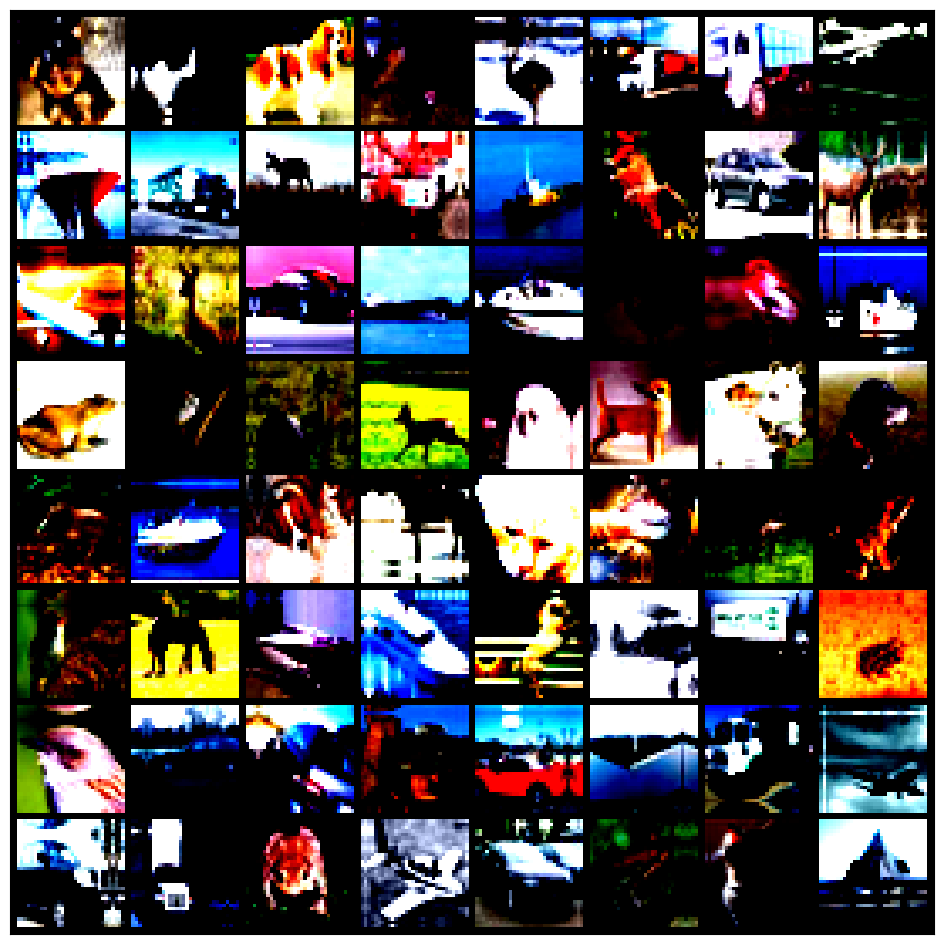

In [62]:
show_batch(train_dl)

Using a GPU

In [63]:
def get_default_device():
    '''Pick GPU if available, else select CPU'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to the chosen device'''
    # If the data is a list or tuple, recursively move each element to the device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    '''Wrap a DataLoader to move data to a device'''

    def __init__(self, dl, device):
        '''Initialize the DeviceDataLoader with a DataLoader and the target device.'''
        self.dl = dl  # The original DataLoader
        self.device = device  # The device (e.g., 'cuda' or 'cpu')

    def __iter__(self):
        '''Yield a batch of data after moving it to the device.'''
        for b in self.dl:
            # Move the entire batch (inputs and labels) to the specified device
            yield to_device(b, self.device)

    def __len__(self):
        '''Return the number of batches in the DataLoader.'''
        return len(self.dl)


Lets check if the GPU is enabled

In [64]:
device = get_default_device()
device

device(type='cuda')

Lets wrap train and validation data on GPU

In [65]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

#Model with residual blocks and batch normalization

We will add residual block in CNN model

A simple residual block

In [66]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1 )
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1 )
    self.relu2= nn.ReLU()


  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + x #Relu can be applied before or after adding the input

We have applied CNN model and added residual block.

in simplier terms it means that we have passed in the input in different layers and in the end we have added the input again in the output

In [67]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  print(images.shape)
  out = simple_resnet(images)
  print(out.shape)
  break


del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])


# We will use the ResNet 9 architecture

In [68]:
import torch.nn.functional as F

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      images, labels = batch
      out = self(images)      #Generate predictions
      loss = F.cross_entropy(out, labels) #Calculate loss
      return loss


    def validation_step(self, batch):
      images, labels = batch
      out = self(images)      #Generate predictions
      loss = F.cross_entropy(out, labels)   #Calculate loss
      acc = accuracy(out, labels) #Calculate accuracy
      return {'val_acc': acc.cpu(), 'val_loss' : loss.cpu()}


    def validation_epoch_end(self,outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean() #Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean() #Combine accuracy
      return {'val_loss' : epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      print('Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
          epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [69]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)]

  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

#This conv_block function takes input channel and output channel and passes it through batchnormalization and then passes the output again form relu

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()


    self.conv1 = conv_block(in_channels, 64) #This is taking the input chanels which is 3 in our case (RGB) and increases it to 64. As it is passed through conv_block that means it will pass the output through batchnorm and then relu layer
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

    self.conv3 = conv_block(128, 256, pool= True)
    self.conv4 = conv_block (256, 512, pool = True)
    self.res2 = nn.Sequential( conv_block(512,512), conv_block(512,512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(512, num_classes))



  def forward (self, xb):   #We took a batch of inputs xb
    out = self.conv1(xb) #passed it thorugh conv1
    out = self.conv2(out) #Passed the output of conv1 thorugh conv2
    out = self.res1(out) + out #Passed the output thorugh 1st residual layer and added the output as well. This is the architecture of Resnet9
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

# Explanation of Resnet9 architecture


def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.Relu(inplace = True)]

  if pool: layers.append(nn.Maxpool2d(2))
  return nn.Sequential(*layers)

**This conv_block function takes input channel and output channel and passes it through batchnormalization and then passes the output again from relu**

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
**Our input is 3 x 32 x 32**

    self.conv1 = conv_block(in_channels, 64)

**This is taking the input chanels which is 3 in our case (RGB) and increases it to 64. As it is passed through conv_block that means it will pass the output through batchnorm and then relu layer**

**it will become 64 x 32 x 32**

    self.conv2 = conv_block(64, 128, pool = True)

**As pool is true it will become 128 x 16 x 16**
    self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))
**This is our first residual block**

**nn.sequential allow us to pass multiple layers as a single layer**

**Output dimension will remain same 128 x 16 x 16 but weights will learn many patterns in this residual layer**

    self.conv3 = conv_block(128, 256, pool= True)

**Now the output will be 256 x 8 x 8**

    self.conv4 = conv_block (256, 512, pool = True)

**Now the output will be 512 x 4 x 4**

    self.res2 = nn.Sequential( conv_block(512,512), conv_block(512,512))

**It will remain same 512 x 4 x 4**

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(512, num_classes))

**In the end we will add a top layer in which we have reduced the maxpoolsize by 4. that means our output now will be 512 x 1 x 1**

**Then we will flatten it and the output will become 512**

**Now we have a vector and we passed it in a single layer with nn.Linear and we selected that the output should be equal to num_Classes**


Lets pass this model to GPU

In [70]:
model = to_device(ResNet9(3, 10) , device)

model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

#Training the model

We will add the following techniques in our fit model:

Learning rate scheduling. We will use 'One cycle learning rate policy'

Weight decay.

Gradient clipping

Lets define fit one cycle which will have all these changes

In [71]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


def fit_one_cycle(epochs, max_lr, model,  train_loader, val_loader,
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

#setup custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
#setup one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))

  for epoch in range(epochs):
    #Training phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #Gradient clipping

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      #Record & update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    #Validation Phase

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history





In [72]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3047478199005127, 'val_acc': 0.09960000962018967}]

We will now train our model, instead of SGD we will use Adam optimizer.

Useful link: https://www.ruder.io/optimizing-gradient-descent/

In [73]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [74]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip = grad_clip,
                         weight_decay = weight_decay,
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 1.2445, val_loss: 1.2697, val_acc: 0.5898
Epoch [1], last_lr: 0.00935, train_loss: 1.0030, val_loss: 1.1430, val_acc: 0.6447
Epoch [2], last_lr: 0.00972, train_loss: 0.7756, val_loss: 0.7156, val_acc: 0.7576
Epoch [3], last_lr: 0.00812, train_loss: 0.5950, val_loss: 0.6325, val_acc: 0.7827
Epoch [4], last_lr: 0.00556, train_loss: 0.4764, val_loss: 0.5371, val_acc: 0.8213
Epoch [5], last_lr: 0.00283, train_loss: 0.3777, val_loss: 0.3836, val_acc: 0.8657
Epoch [6], last_lr: 0.00077, train_loss: 0.2660, val_loss: 0.3002, val_acc: 0.8950
Epoch [7], last_lr: 0.00000, train_loss: 0.1859, val_loss: 0.2705, val_acc: 0.9083
CPU times: user 30.5 s, sys: 4.05 s, total: 34.6 s
Wall time: 4min 55s


In [75]:
train_time = '4:55'

Lets plot the accuracies to view how the model improves over time

In [76]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')


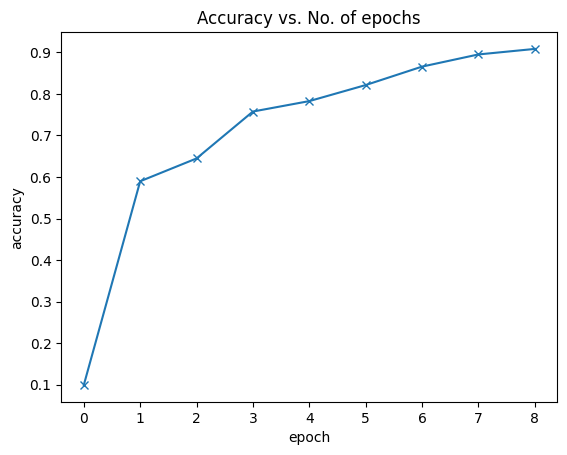

In [77]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend

In [78]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

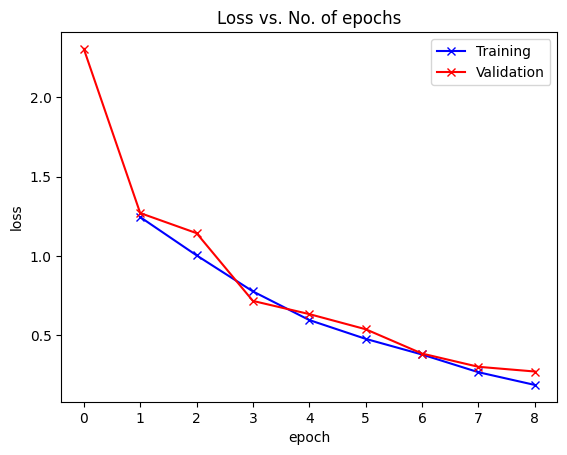

In [79]:
plot_losses(history)

Let's visualize how the learning rate changed over time, batch by batch over all the batches

In [80]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title

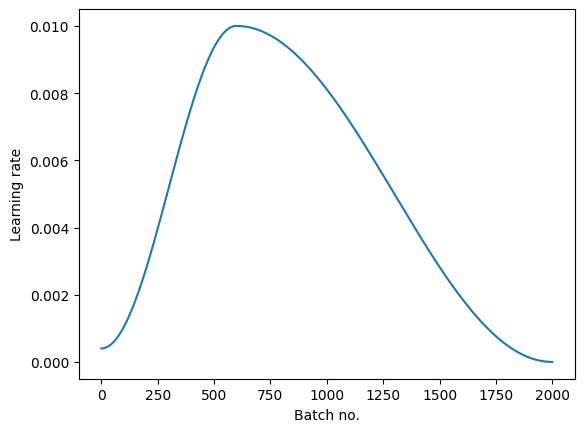

In [81]:
plot_lrs(history)

# Lets test the model on test images

In [82]:
def predict_image(img, model):
  #Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  #Get predictions from model
  yb = model(xb)
  #Pick index with highest probability
  _, preds = torch.max(yb, dim = 1)
  #Retrieve the class label
  return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


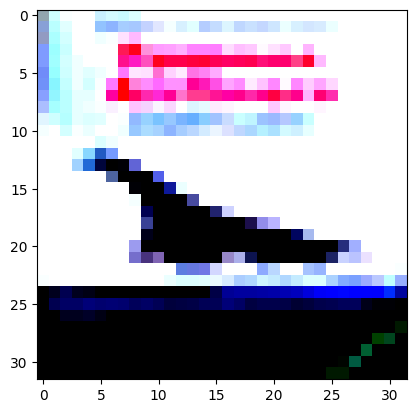

In [83]:
img, label = valid_ds[0]
plt.imshow(img.permute(1,2,0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


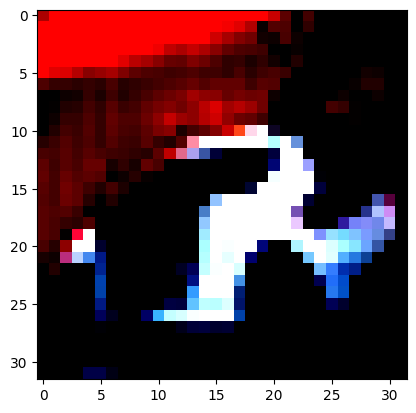

In [84]:
img, label = valid_ds[1000]
plt.imshow(img.permute(1,2,0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


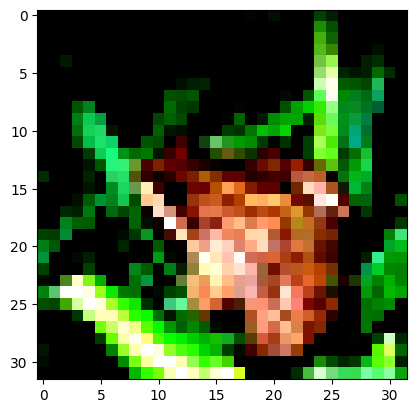

In [85]:
img, label = valid_ds[6000]
plt.imshow(img.permute(1,2,0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


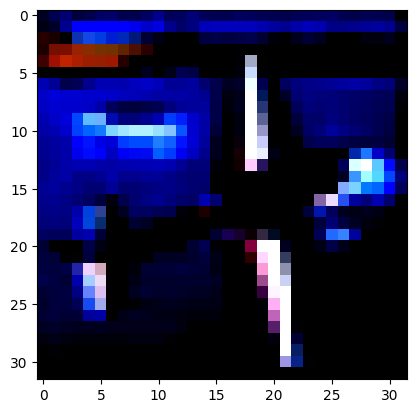

In [87]:
img, label = valid_ds[370]
plt.imshow(img.permute(1,2,0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

#Saving the model

In [88]:
torch.save(model.state_dict(), 'Resnet9-cifar10.pth')